In [ ]:
%pip install -q -U torch transformers bitsandbytes accelerate sentencepiece protobuf

In [ ]:
%pip install sentencepiece protobuf

In [ ]:
%pip install pandas datasets trl

Based on https://www.kaggle.com/code/optimo/kaira-adapting-gemma2-to-local-slang-french

Using pre-generated dataset from https://www.kaggle.com/datasets/optimo/french-kaira-training?resource=download

Training in QLora 4bits because that's the only quantization I was able to fit on my 407-Ti, need to tests with Strix Halo

In [1]:
import torch
import gc
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer, SFTConfig

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"
NEW_MODEL_NAME = "mistral-7b-kaira"

#  4-Bit Quantization Config (Fits in ~6GB VRAM)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)
CSV_FILE_PATH = "french_argot_train.csv" 

#MAX_LENGTH_LIMIT = 1024
MAX_LENGTH_LIMIT = 2048


In [2]:
# 1. Load Base Model
print("⏳ Loading Mistral 7B...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    # use_cache=False is needed for training with gradient checkpointing
    use_cache=False 
)
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()

# 2. Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# FIX: Mistral doesn't have a pad token by default, which causes training errors.
# We set it to the unknown token or eos token.
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix for fp16 training stability

⏳ Loading Mistral 7B...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# Load CSV
df = pd.read_csv(CSV_FILE_PATH)

# Verify we see your columns
print(f"Columns found: {df.columns.tolist()}")

# Convert to Dataset
dataset = Dataset.from_pandas(df)

# Formatting Function
# Goal: Teach the model to take Standard French and output Verlan.
def format_instruction(sample):
    # Standard French
    source_text = sample['story'] 
    # Verlan Target
    target_text = sample['verlan_story']
    
    # Prompt: "Rewrite this text in Verlan slang"
    prompt = f"<s>[INST] Réécris le texte suivant en style Verlan :\n{source_text} [/INST] {target_text} </s>"
    return prompt

Columns found: ['input_text', 'word_list', 'model_name', 'story', 'verlan_story', 'fold']


📊 Analyzing Token Lengths...


  0%|          | 0/6697 [00:00<?, ?it/s]


     TOKEN LENGTH REPORT
Total Samples:       6697
Max Length Found:    1803 tokens
Min Length Found:    103 tokens
Average Length:      909 tokens
Median Length:       915 tokens
------------------------------
Samples > 2048:      0
Truncation Rate:     0.00%

✅ SAFE: 2048 is perfect. No data is being lost.


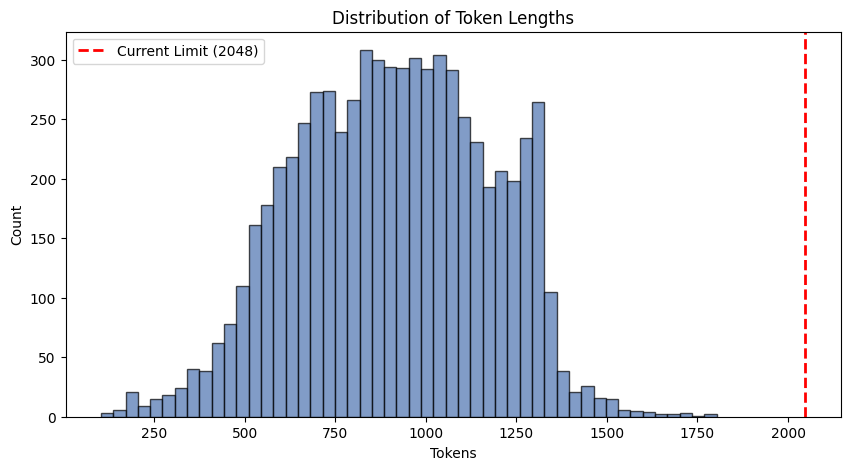

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

print("📊 Analyzing Token Lengths...")

token_lengths = []
truncated_samples = 0

# Loop through the dataset
for i in tqdm(range(len(dataset))):
    # 1. Generate the full formatted text
    # We use the same function the trainer uses
    full_prompt = format_instruction(dataset[i])
    
    # 2. Tokenize without truncation to get the "True" length
    # return_tensors='pt' adds a batch dimension, so we take len of [0]
    tokens = tokenizer(full_prompt, add_special_tokens=True).input_ids
    length = len(tokens)
    
    token_lengths.append(length)
    if length > MAX_LENGTH_LIMIT:
        truncated_samples += 1

# --- REPORT ---
token_lengths = np.array(token_lengths)

print("\n" + "="*30)
print("     TOKEN LENGTH REPORT")
print("="*30)
print(f"Total Samples:       {len(dataset)}")
print(f"Max Length Found:    {token_lengths.max()} tokens")
print(f"Min Length Found:    {token_lengths.min()} tokens")
print(f"Average Length:      {int(token_lengths.mean())} tokens")
print(f"Median Length:       {int(np.median(token_lengths))} tokens")
print("-" * 30)
print(f"Samples > {MAX_LENGTH_LIMIT}:      {truncated_samples}")
print(f"Truncation Rate:     {truncated_samples / len(dataset) * 100:.2f}%")
print("="*30)

# Recommendation Logic
if truncated_samples == 0:
    print(f"\n✅ SAFE: {MAX_LENGTH_LIMIT} is perfect. No data is being lost.")
elif (truncated_samples / len(dataset)) < 0.05:
    print("\n⚠️ ACCEPTABLE: A few long stories will be cut, but <5% is usually okay.")
else:
    print(f"\n❌ DANGER: You are truncating {truncated_samples} stories.")
    print(f"👉 Recommendation: Increase max_length to {int(np.percentile(token_lengths, 99))} (covers 99% of data).")

# Visual Histogram
plt.figure(figsize=(10, 5))
plt.hist(token_lengths, bins=50, color='#4c72b0', alpha=0.7, edgecolor='black')
plt.axvline(MAX_LENGTH_LIMIT, color='red', linestyle='dashed', linewidth=2, label=f'Current Limit ({MAX_LENGTH_LIMIT})')
plt.title("Distribution of Token Lengths")
plt.xlabel("Tokens")
plt.ylabel("Count")
plt.legend()
plt.show()

In [5]:
model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj", 
#        "gate_proj", "up_proj", "down_proj"
    ],
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
print("Model Ready for training")

trainable params: 13,631,488 || all params: 7,261,655,040 || trainable%: 0.1877
Model Ready for training


In [6]:
# Force Cleanup
gc.collect()
torch.cuda.empty_cache()

# --- NEW CONFIGURATION OBJECT ---
# SFTConfig inherits from TrainingArguments but adds SFT-specific params like max_seq_length
training_arguments = SFTConfig(
    output_dir=f"./{NEW_MODEL_NAME}",
    max_length=MAX_LENGTH_LIMIT,             
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    optim="paged_adamw_8bit",        
    save_steps=50,
    logging_steps=10,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    gradient_checkpointing=True,     # Keeping your memory fix
    gradient_checkpointing_kwargs={"use_reentrant": False}, # Often needed to avoid warnings
    dataset_text_field="text",       # SFTConfig requires this or packing=False logic
    packing=False
)

# --- TRAINER ---
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    formatting_func=format_instruction,
    processing_class=tokenizer,
    args=training_arguments,     
)

print("🚀 Starting Training...")
trainer.train()

print("✅ Training Complete!")
trainer.model.save_pretrained(NEW_MODEL_NAME)

/home/tiry/tairy/notebooks/venv-cuda/lib/python3.13/site-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
/home/tiry/tairy/notebooks/venv-cuda/lib/python3.13/site-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Applying formatting function to train dataset:   0%|          | 0/6697 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/6697 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/6697 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/6697 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


🚀 Starting Training...


Step,Training Loss
10,1.286700
20,1.171800
30,1.155900
40,1.127000
50,1.181200
60,1.003300
70,1.002300
80,0.979900
90,0.931500
100,0.961600


✅ Training Complete!
